In [197]:
import numpy as np
import h5py
import os
from scipy.stats import multivariate_normal, norm
from scipy import linalg
from sklearn.covariance import LedoitWolf
import pandas as pd
from scipy.cluster.hierarchy import linkage, leaves_list, optimal_leaf_ordering
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [198]:
def plot_corr_cov_prec(corr,cov,prec,figname=None):

    # get the optimal leaf order    
    Z = linkage(corr, 'average', 'euclidean',optimal_ordering=True)
    idx_rows = leaves_list(optimal_leaf_ordering(Z, corr))

    fig, axes = plt.subplots(1,3,figsize=(30,10))

    ax = axes[0]
    h = ax.imshow(corr[idx_rows,:][:,idx_rows],cmap='RdBu_r',vmin=-1,vmax=1,origin='lower',interpolation='none')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax)
    ax.set_title('Correlation matrix')

    ax = axes[1]
    h = ax.imshow(cov[idx_rows,:][:,idx_rows],cmap='RdBu_r',origin='lower',interpolation='none', norm=mcolors.TwoSlopeNorm(vcenter=0))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax)
    ax.set_title('Covariance matrix')

    ax = axes[2]
    h = ax.imshow(prec[idx_rows,:][:,idx_rows],cmap='RdBu_r',origin='lower',interpolation='none', norm=mcolors.TwoSlopeNorm(vcenter=0))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax)
    ax.set_title('Precision matrix')    

    if figname is not None:
        fig.savefig(figname)

0.5424513677802493


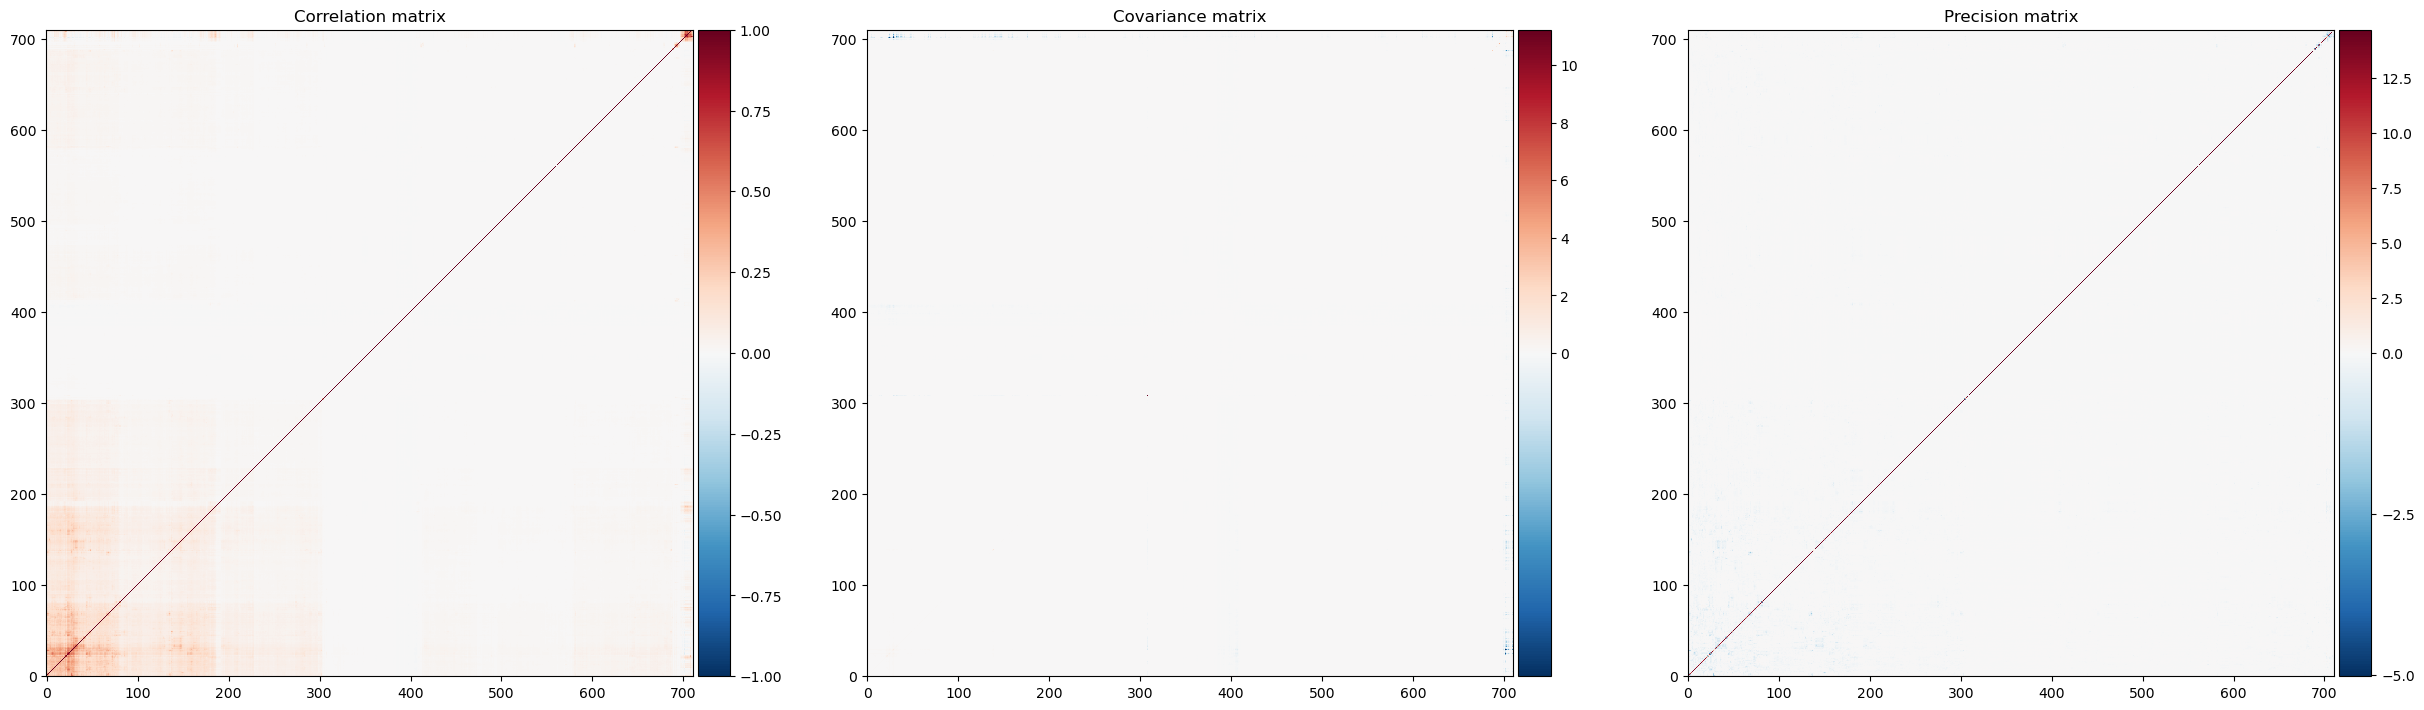

In [202]:
genome = 'mm10'
#genome = 'hg38'
window_kb = 5
bin_size = 10

# get binned chip signal per tf per prom
infile = f'../results/{genome}/svd/Window_pm{window_kb}kb_bin_size_{bin_size}/tensor_TFsvd1_prom.hdf5'
with h5py.File(infile,'r') as hf:
    X_gf = hf['tf_prom'][:].T
    TFs = hf['tf'][:]

# Ledoit-Wolf shrinkage method for covariance and precision matrix estimation
lw = LedoitWolf(assume_centered=False).fit(X_gf)
my_cov  = lw.covariance_
my_prec = lw.precision_
print(lw.shrinkage_)

# correlation matrix
my_corr = np.diag(np.power( np.diag(my_cov),-1/2)) @ my_cov @ np.diag(np.power( np.diag(my_cov),-1/2))

# plot
plot_corr_cov_prec(my_corr,my_cov,my_prec)

In [200]:
[n_g,n_tf] = X_gf.shape

P={}
P['cond'] = np.zeros([n_g,n_tf])
P['marg'] = np.zeros([n_g,n_tf])
Z = {}
Z['cond'] = np.zeros([n_g,n_tf])
Z['marg'] = np.zeros([n_g,n_tf])

idx_tf = np.arange(n_tf)
for idx_1 in idx_tf:

    if idx_1 % 10 == 0:
        print(f'{idx_1/n_tf*100:.2f}%',end='\r')

    idx_2 = np.delete(idx_tf, idx_1)

    x_1 = X_gf[:,idx_1]
    x_2 = X_gf[:,idx_2]

    # get mean of x_1 and x_2 across all genes
    μ_1 = x_1.mean()
    μ_2 = x_2.mean(axis=0)

    # get covariance matrix of x_1
    Σ_11 = my_cov[idx_1,idx_1]
    
    # get conditional precision matrix of x_1 given x_2
    Λ_11_inv = 1/my_prec[idx_1,idx_1]
    Λ_12 = my_prec[idx_1,idx_2]
    Σ_cond = Λ_11_inv

    # get conditional mean of x_1 given x_2 for all genes
    μ_cond = (μ_1 - (Λ_11_inv * Λ_12) @ (x_2 - μ_2).T )

    # get cdf for x_1 given x_2 and marginal x_1
    P['cond'][:,idx_1] = norm.cdf(x_1,loc=μ_cond, scale=np.sqrt(Σ_cond))
    P['marg'][:,idx_1] = norm.cdf(x_1,loc=μ_1   , scale=np.sqrt(Σ_11))
    
    # get Z-scores for x_1 given x_2 and marginal x_1
    Z['cond'][:,idx_1] = (x_1 - μ_cond) / np.sqrt(Σ_cond)
    Z['marg'][:,idx_1] = (x_1 - μ_1) / np.sqrt(Σ_11)


outfolder = f'../results/{genome}/Expected_chip_signal_cond_on_TFs/Window_pm{window_kb}kb_bin_size_{bin_size}/'

if not os.path.exists(outfolder):
    os.makedirs(outfolder)

outfile = f'{outfolder}Expected_chip_signal_cond_on_TFs.hdf5'

with h5py.File(outfile,'w') as hf:
    hf.create_dataset('P_cond',data=P['cond'])
    hf.create_dataset('P_marg',data=P['marg'])
    hf.create_dataset('Z_cond',data=Z['cond'])
    hf.create_dataset('Z_marg',data=Z['marg'])
    hf.create_dataset('TFs',data=TFs)

TypeError: No conversion path for dtype: dtype('<U8')

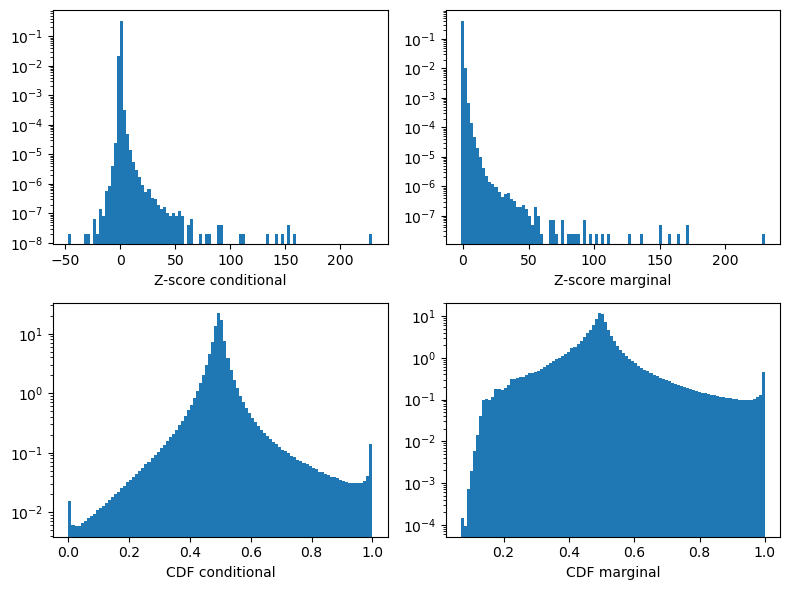

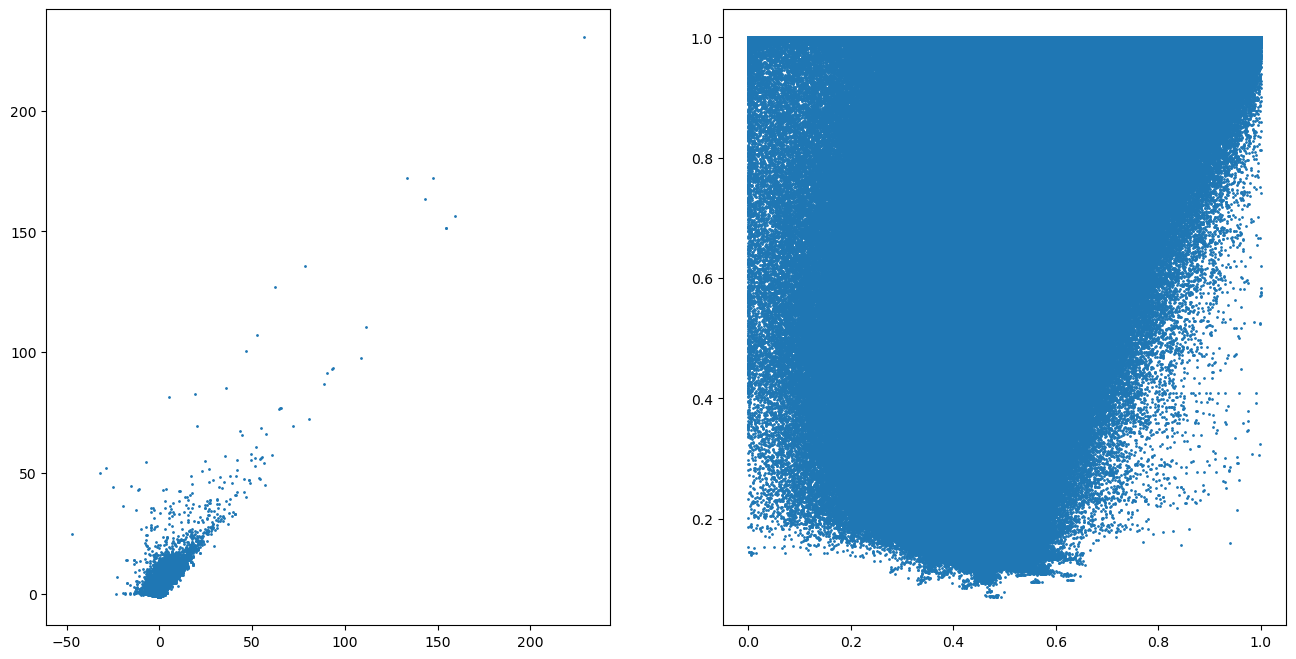

In [205]:
fig, axes = plt.subplots(2,2,figsize=(8,6))

ax = axes.flatten()[0]
_ = ax.hist(Z['cond'].flatten(),bins=100,density=True)
ax.set_yscale('log')
ax.set_xlabel('Z-score conditional')

ax = axes.flatten()[1]
_ = ax.hist(Z['marg'].flatten(),bins=100,density=True)
ax.set_yscale('log')
ax.set_xlabel('Z-score marginal')

ax = axes.flatten()[2]
_ = ax.hist(P['cond'].flatten(),bins=100,density=True)
ax.set_yscale('log')
ax.set_xlabel('CDF conditional')

ax = axes.flatten()[3]
_ = ax.hist(P['marg'].flatten(),bins=100,density=True)
ax.set_yscale('log')
ax.set_xlabel('CDF marginal')

fig.tight_layout()


fig, axes = plt.subplots(1,2,figsize=(16,8))

ax = axes[0]
ax.scatter(Z['cond'].flatten(),Z['marg'].flatten(),s=1,alpha=0.1)

ax = axes[1]
ax.scatter(P['cond'].flatten(),P['marg'].flatten(),s=1,alpha=0.1)